In [15]:
# augmenting the dataset the following data to create super rows
# - last 5 / 10 games PTS, REB, AST, MIN, FGA
# - home game flag
# - back-to-back flag
# - season-level stats (season averages, shooting %, etc.)

import pandas as pd
import numpy as np

# load per game data
games = pd.read_csv("../data/nba_games_with_travel.csv")

# load season data
season = pd.read_csv("../data/nba_player_stats_2016_2024.csv")

# sort data
games["GAME_DATE"] = pd.to_datetime(games["GAME_DATE"])
games = games.sort_values(["PLAYER_ID", "GAME_DATE"])

# get previous season label
def get_prev_season(season_label):
    year1 = int(season_label.split("-")[0])
    prev_year1 = year1 - 1
    prev_year2 = str((prev_year1 + 1) % 100).zfill(2)
    return f"{prev_year1}-{prev_year2}"

games["PREV_SEASON"] = games["SEASON_LABEL"].apply(get_prev_season)

# keep useful season columns
season_cols_useful = [
    "PLAYER_ID", "SEASON",
    "PTS", "REB", "AST", "MIN",
    "FG_PCT", "FG3_PCT", "FT_PCT"
]

# rename to not conflict with per game columns
season_stat = season[season_cols_useful].rename(columns={
    "PTS": "SEASON_PTS",
    "REB": "SEASON_REB",
    "AST": "SEASON_AST",
    "MIN": "SEASON_MIN",
    "FG_PCT": "SEASON_FG_PCT",
    "FG3_PCT": "SEASON_FG3_PCT",
    "FT_PCT": "SEASON_FT_PCT"
})

# merge to super row
df = games.merge(
    season_stat,
    left_on=["PLAYER_ID", "PREV_SEASON"],
    right_on=["PLAYER_ID", "SEASON"],
    how="left"
)
df = df.sort_values(["PLAYER_ID", "GAME_DATE"])

# calculate rolling stats
rolling_stats = ["PTS", "REB", "AST", "MIN", "FGA",
                 "FG_PCT", "FG3_PCT", "FT_PCT"]
for stat in rolling_stats:
    if stat not in df.columns:
        print(f"Warning: '{stat}' not in df.columns, skipping rolling features for it.")
        continue

    df[f"{stat}_LAST5"] = (
        df.groupby("PLAYER_ID")[stat]
          .rolling(5)
          .mean()
          .reset_index(0, drop=True)
    )
    df[f"{stat}_LAST10"] = (
        df.groupby("PLAYER_ID")[stat]
          .rolling(10)
          .mean()
          .reset_index(0, drop=True)
    )

# add home_game columns and b2b columns
df["HOME_GAME"] = df["MATCHUP"].str.contains("vs").astype(int)
df["BACK_TO_BACK"] = (df["DAYS_REST"] == 1).astype(int)

# delete NaN
df = df.fillna(0)

# save csv
df.to_csv("../data/final_dataset.csv", index=False)
print("final_dataset.csv created")
print("Shape:", df.shape)

final_dataset.csv created
Shape: (202129, 62)


In [16]:
from sklearn.model_selection import train_test_split

#load dataset
df = pd.read_csv("../data/final_dataset.csv")

features = [
    # last 5 and las 10
    "PTS_LAST5", "PTS_LAST10",
    "REB_LAST5", "REB_LAST10",
    "AST_LAST5", "AST_LAST10",
    "MIN_LAST5", "MIN_LAST10",
    "FGA_LAST5", "FGA_LAST10",
    "FG_PCT_LAST5", "FG_PCT_LAST10",
    "FG3_PCT_LAST5", "FG3_PCT_LAST10",
    "FT_PCT_LAST5", "FT_PCT_LAST10",

    # travel
    "DISTANCE_TRAVELED_KM",
    "DAYS_REST",
    "BACK_TO_BACK",
    "HOME_GAME",

    # season features
    "SEASON_PTS", "SEASON_REB", "SEASON_AST",
    "SEASON_MIN", "SEASON_FG_PCT",
    "SEASON_FG3_PCT", "SEASON_FT_PCT"
]


target = "PTS"

#make sure no NaN
df = df.dropna(subset=features + [target])

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1
)



In [17]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, preds, feature_names):
    
    #metrics
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    print("\nMODEL RESULTS")
    print(f"RMSE: {rmse:.3f}")
    print(f"R² Score: {r2:.3f}")

    # Convert to arrays for plotting
    y_true = np.array(y_test)
    y_pred = np.array(preds)


    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=8, alpha=0.25)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color="red", lw=2)
    plt.title("Predicted vs Actual Points")
    plt.xlabel("Actual Points")
    plt.ylabel("Predicted Points")
    plt.grid(alpha=0.3)
    plt.show()


    errors = y_true - y_pred

    plt.figure(figsize=(7,4))
    plt.hist(errors, bins=40, color="skyblue", alpha=0.85)
    plt.title("Prediction Residuals (Actual − Predicted)")
    plt.xlabel("Error (Points)")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()

    return rmse, r2

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=20, n_estimators=400; total time=  21.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=20, n_estimators=400; total time=  18.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=20, n_estimators=400; total time=  19.6s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=400; total time=  14.0s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=400; total time=  13.3s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=400; total time=  13.2s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estimators=600; total time=  20.3s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=20, n_estima

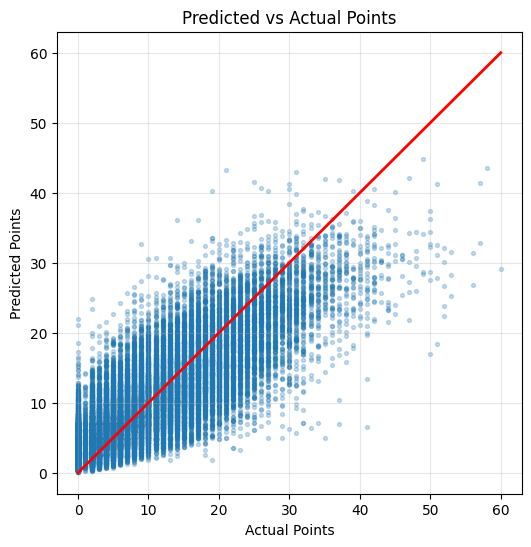

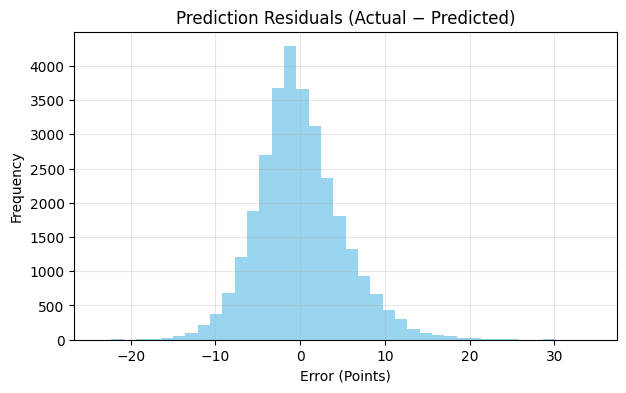

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [400, 600, 800],
    'max_features': ['sqrt', 'log2'], # Try using fewer features per split
    'max_depth': [15, 20, 30, None],
    'min_samples_split': [4, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize a base model
rf = RandomForestRegressor(random_state=1, n_jobs=-1)

# Initialize the search (RandomizedSearch is faster than GridSearch)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                               n_iter=20, cv=3, verbose=2, random_state=1, scoring='neg_root_mean_squared_error')

# Fit the random search model
rf_random.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", rf_random.best_params_)
preds = rf_random.predict(X_test)

# print rmse, r2, and draw graph
rf_rmse, rf_r2 = evaluate_model(
    model = rf_random,
    X_test = X_test,
    y_test = y_test,
    preds = preds,
    feature_names = features
)


Tuning Gradient Boosting with Early Stopping... (This will be much faster)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 4, 'learning_rate': 0.2}
The best model converged after 30 trees.

MODEL RESULTS
RMSE: 5.064
R² Score: 0.653


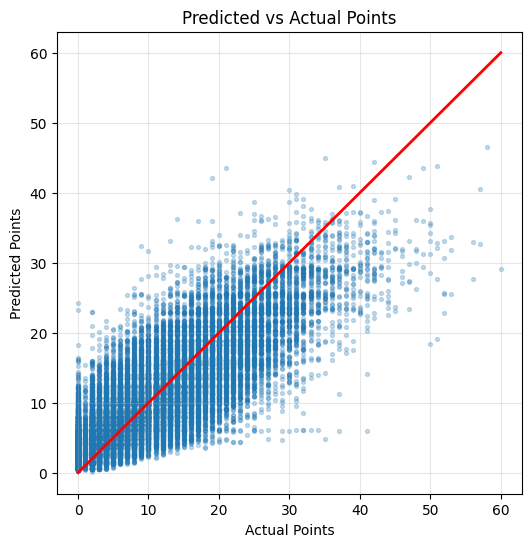

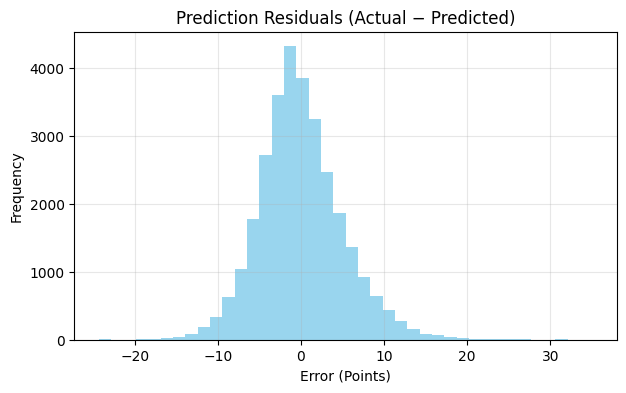

(5.063987165409297, 0.6525145627308171)

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

gb_param_grid_optimized = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

gb = GradientBoostingRegressor(
    random_state=1,
    n_estimators=1000,       # The maximum limit (ceiling)
    validation_fraction=0.1, # Use 10% of training data to monitor error
    n_iter_no_change=5,      # Stop if no improvement for 5 consecutive trees
    tol=0.01                 # Minimum improvement required to keep going
)

# Initialize Random Search
gb_random = RandomizedSearchCV(
    estimator=gb, 
    param_distributions=gb_param_grid_optimized,
    n_iter=20, 
    cv=3, 
    verbose=1, 
    random_state=1, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit the model
print("Tuning Gradient Boosting with Early Stopping... (This will be much faster)")
gb_random.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", gb_random.best_params_)

# OPTIONAL: Check how many trees were actually built
# Since we used early stopping, this number will likely be less than 1000
actual_trees = gb_random.best_estimator_.n_estimators_
print(f"The best model converged after {actual_trees} trees.")

# Use the best model to predict
best_gb_preds = gb_random.best_estimator_.predict(X_test)

# Evaluate (assuming you have your evaluate_model function defined)
evaluate_model(gb_random.best_estimator_, X_test, y_test, best_gb_preds, features)

Tuning HistGradientBoosting... (This should be fast!)
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'min_samples_leaf': 50, 'max_iter': 500, 'max_depth': 3, 'learning_rate': 0.05, 'l2_regularization': 0.1}


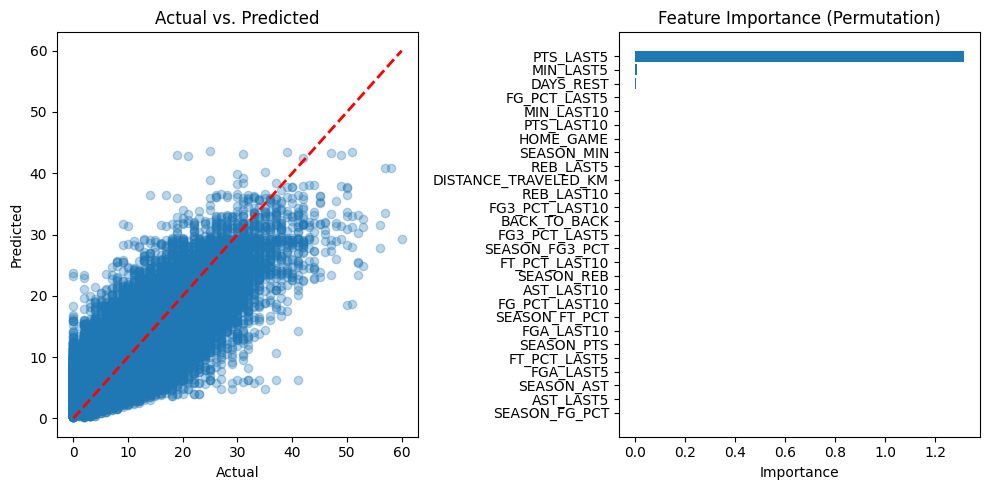


MODEL RESULTS
RMSE: 5.064
R² Score: 0.653


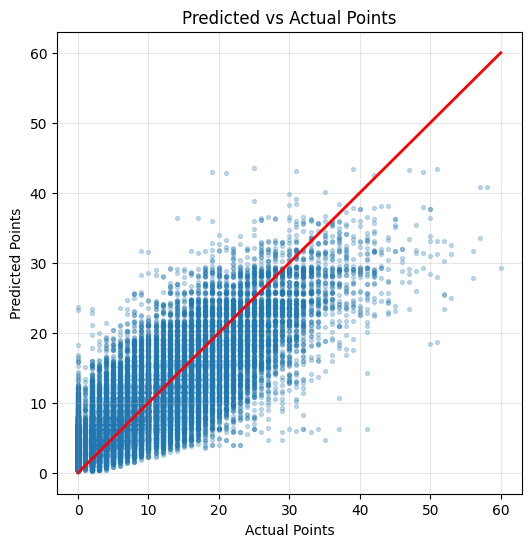

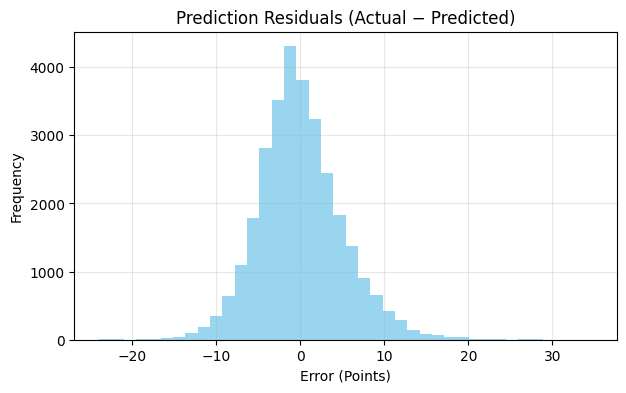

In [25]:
from sklearn.ensemble import HistGradientBoostingRegressor
# another regressor from ensemble

hgb_model = HistGradientBoostingRegressor(
    learning_rate = 0.05,
    max_depth = 8,
    max_iter = 300,      
    random_state = 1,
    verbose = 1
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

# 1. Define Parameter Grid (Adapted for HistGradientBoosting)
hgb_param_grid = {
    # 'max_iter' replaces 'n_estimators'
    'max_iter': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    # Regularization
    'l2_regularization': [0, 0.1, 1.0], 
    'min_samples_leaf': [10, 20, 50]
}

# 2. Initialize Model
hgb = HistGradientBoostingRegressor(random_state=1)

# 3. Random Search (Same setup, faster execution)
hgb_random = RandomizedSearchCV(
    estimator=hgb, 
    param_distributions=hgb_param_grid,
    n_iter=20, 
    cv=3, 
    verbose=1, 
    random_state=1, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# 4. Fit Model
print("Tuning HistGradientBoosting... (This should be fast!)")
hgb_random.fit(X_train, y_train)

print(f"Best Parameters: {hgb_random.best_params_}")

# --- VISUALIZATION SECTION ---

# Get the best model
best_model = hgb_random.best_estimator_
best_preds = best_model.predict(X_test)

# Plot 1: Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, best_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

# Plot 2: Permutation Feature Importance
# Note: HGBR doesn't use standard .feature_importances_, we use permutation instead
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

plt.subplot(1, 2, 2)
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Importance")
plt.title("Feature Importance (Permutation)")

plt.tight_layout()
plt.show()



hgb_rmse, hgb_r2 = evaluate_model(
    model = best_model,
    X_test = X_test,
    y_test = y_test,
    preds = best_preds,
    feature_names = features
)



Tuning Decision Tree...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'max_depth': 10}

MODEL RESULTS
RMSE: 5.210
R² Score: 0.632


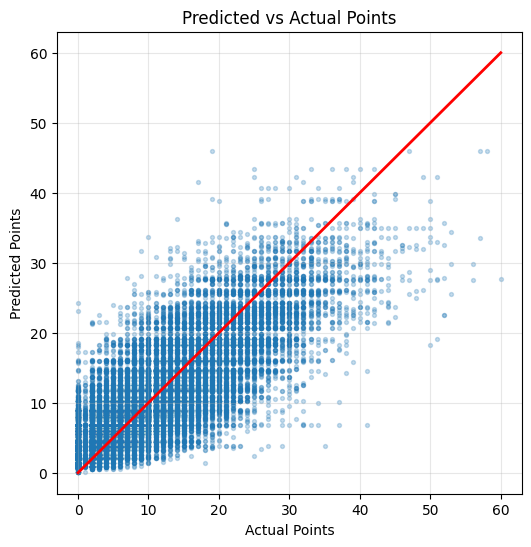

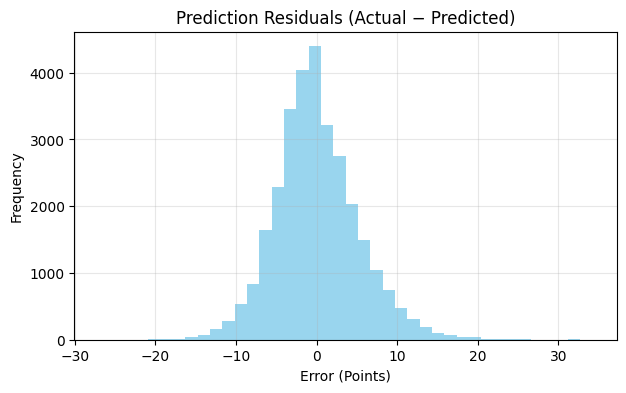

(5.210253603054656, 0.632151371538227)

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

# 1. Define the range of parameters to test
#    Broad ranges allow the model to explore different complexities
param_dist = {
    'max_depth': [None, 10, 15, 20, 30],         # Controls tree height
    'min_samples_split': [2, 10, 20, 50],        # Higher values prevent overfitting
    'min_samples_leaf': [1, 5, 10, 20],          # Controls leaf size
    'max_features': ['sqrt', 'log2']       # Features to consider at each split
}

# 2. Initialize the base model
dt = DecisionTreeRegressor(random_state=1)

# 3. Set up the fast search
#    n_iter=50 means it tries 50 random combinations (adjust for speed vs. thoroughness)
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=50,             # Tries 50 candidates
    cv=5,                  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,             # Use all CPU cores
    verbose=1,
    random_state=1
)

# 4. Fit the model
print("Tuning Decision Tree...")
random_search.fit(X_train, y_train)

# 5. Get best results
print(f"Best Parameters: {random_search.best_params_}")

# 6. Use the best model for prediction
best_dt_model = random_search.best_estimator_
best_dt_preds = best_dt_model.predict(X_test)

# 7. Evaluate (Using your custom function or standard metrics)
# Assuming 'evaluate_model' is your custom function from previous steps:
evaluate_model(best_dt_model, X_test, y_test, best_dt_preds, features)


Training ARIMA model for Player ID: 1627741
Train samples: 537, Test samples: 95

ARIMA RESULTS for Player 1627741
RMSE: 7.149


c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

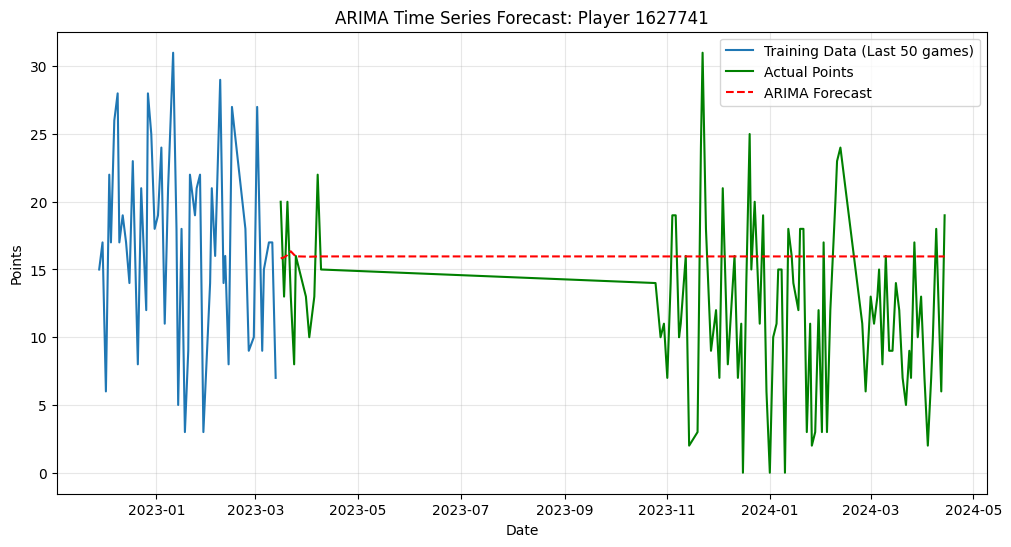

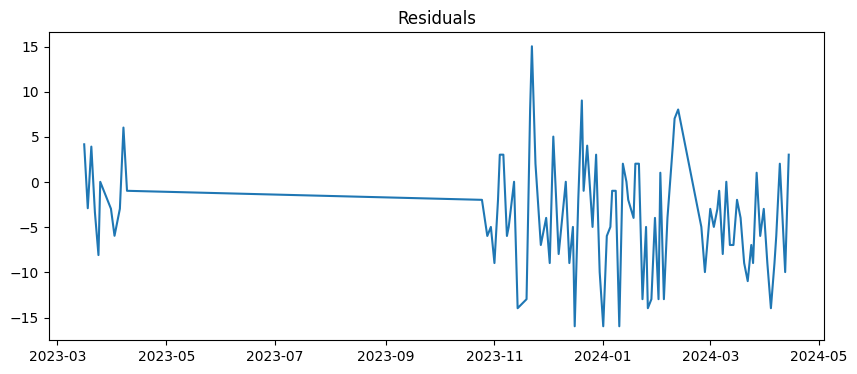

In [12]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# 1. PREPARE DATA FOR TIME SERIES
# ARIMA requires a single sequence of data sorted by time.
# We cannot feed it the whole mixed dataset. Let's pick the player with the most games.
most_frequent_player_id = df['PLAYER_ID'].value_counts().idxmax()
player_name_guess = "Player " + str(most_frequent_player_id) # We don't have the name column, just ID

print(f"Training ARIMA model for Player ID: {most_frequent_player_id}")

# Filter for this specific player and sort by date
player_df = df[df['PLAYER_ID'] == most_frequent_player_id].copy()
player_df['GAME_DATE'] = pd.to_datetime(player_df['GAME_DATE'])
player_df = player_df.sort_values('GAME_DATE')

# Set the date as index and pick the target series (Points)
# ARIMA only looks at the target variable history, it ignores other features like 'HOME_GAME'
time_series = player_df.set_index('GAME_DATE')['PTS']

# 2. SPLIT TRAIN AND TEST (Chronological Split)
# We take the last 15% of games as the test set
split_index = int(len(time_series) * 0.85)
train_pts = time_series.iloc[:split_index]
test_pts = time_series.iloc[split_index:]

print(f"Train samples: {len(train_pts)}, Test samples: {len(test_pts)}")

# 3. DEFINE AND FIT ARIMA MODEL
# Order (p,d,q) parameters:
# p=5: Look at last 5 games (AutoRegressive part)
# d=1: Difference the data once to make it stationary (Integrated part)
# q=1: Moving Average part
# You can tweak these numbers or use a library like 'pmdarima' to find the best ones automatically.
arima_model = ARIMA(train_pts, order=(5, 1, 1)) 
arima_result = arima_model.fit()

# 4. FORECAST
# Predict the points for the test period
start_idx = len(train_pts)
end_idx = len(train_pts) + len(test_pts) - 1
arima_preds = arima_result.predict(start=start_idx, end=end_idx, typ='levels')

# Align the index for plotting
arima_preds.index = test_pts.index

# 5. EVALUATE
arima_rmse = mean_squared_error(test_pts, arima_preds, squared=False)
print(f"\nARIMA RESULTS for Player {most_frequent_player_id}")
print(f"RMSE: {arima_rmse:.3f}")

# 6. VISUALIZE
plt.figure(figsize=(12, 6))
plt.plot(train_pts.index[-50:], train_pts.iloc[-50:], label='Training Data (Last 50 games)')
plt.plot(test_pts.index, test_pts, label='Actual Points', color='green')
plt.plot(arima_preds.index, arima_preds, label='ARIMA Forecast', color='red', linestyle='--')
plt.title(f"ARIMA Time Series Forecast: Player {most_frequent_player_id}")
plt.xlabel("Date")
plt.ylabel("Points")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Optional: Show residuals (errors)
residuals = test_pts - arima_preds
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

Training SARIMA model for Player ID: 1627741
Fitting SARIMA model... (this may take a moment)

SARIMA RESULTS for Player 1627741
RMSE: 7.177


c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\neolu\anaconda3\envs\final441\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported

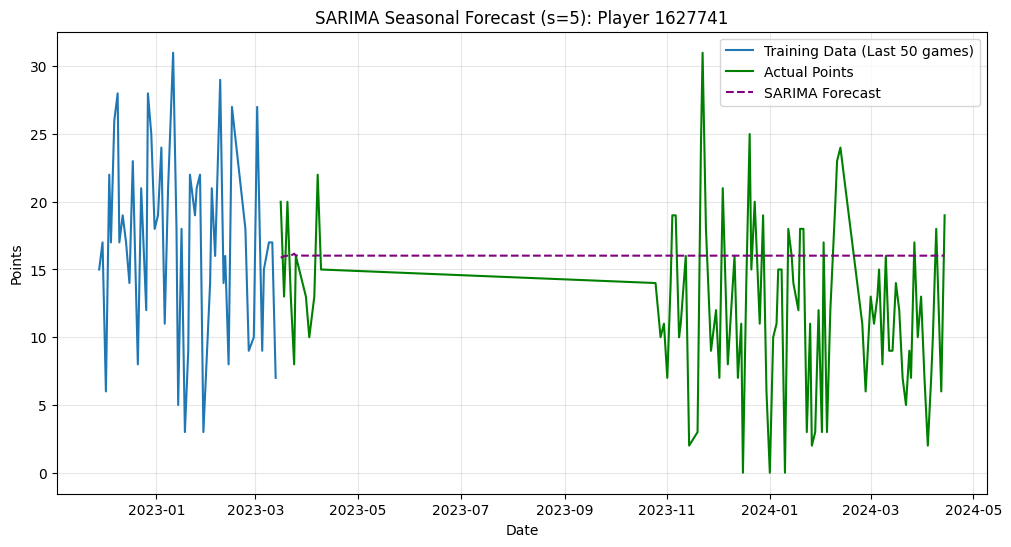

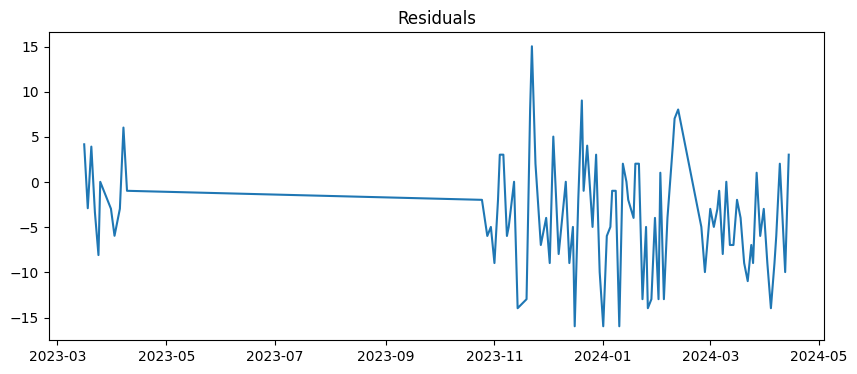

In [27]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pandas as pd

# 1. PREPARE DATA (Same as before)
if 'most_frequent_player_id' not in locals():
    most_frequent_player_id = df['PLAYER_ID'].value_counts().idxmax()

print(f"Training SARIMA model for Player ID: {most_frequent_player_id}")

player_df = df[df['PLAYER_ID'] == most_frequent_player_id].copy()
player_df['GAME_DATE'] = pd.to_datetime(player_df['GAME_DATE'])
player_df = player_df.sort_values('GAME_DATE')

# Set date index and pick target
time_series = player_df.set_index('GAME_DATE')['PTS']

# 2. SPLIT TRAIN AND TEST
split_index = int(len(time_series) * 0.85)
train_pts = time_series.iloc[:split_index]
test_pts = time_series.iloc[split_index:]

# 3. DEFINE SARIMA MODEL
# UPDATED: Changed p from 5 to 2 to avoid conflict with s=5
sarima_model = SARIMAX(train_pts, 
                       order=(2, 1, 1),              # Reduced p to 2
                       seasonal_order=(1, 0, 1, 5),  # Seasonality stays 5
                       enforce_stationarity=False,
                       enforce_invertibility=False)

print("Fitting SARIMA model... (this may take a moment)")
sarima_result = sarima_model.fit(disp=False)

# 4. FORECAST
start_idx = len(train_pts)
end_idx = len(train_pts) + len(test_pts) - 1
sarima_preds = sarima_result.predict(start=start_idx, end=end_idx, typ='levels')
sarima_preds.index = test_pts.index

# 5. EVALUATE
sarima_rmse = mean_squared_error(test_pts, sarima_preds, squared=False)
print(f"\nSARIMA RESULTS for Player {most_frequent_player_id}")
print(f"RMSE: {sarima_rmse:.3f}")

# 6. VISUALIZE
plt.figure(figsize=(12, 6))
plt.plot(train_pts.index[-50:], train_pts.iloc[-50:], label='Training Data (Last 50 games)')
plt.plot(test_pts.index, test_pts, label='Actual Points', color='green')
plt.plot(sarima_preds.index, sarima_preds, label='SARIMA Forecast', color='purple', linestyle='--')
plt.title(f"SARIMA Seasonal Forecast (s=5): Player {most_frequent_player_id}")
plt.xlabel("Date")
plt.ylabel("Points")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

residuals = test_pts - arima_preds
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals")
plt.show()